# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 3: Neural Machine Translation (30 pts)
In this part, you implement Transformer encoder for Neural Machine Translation (NMT) using a sequence to sequence (seq2seq) model for English to French translation with PyTorch.

---
### 1 Transformer Encoder (18 pts)

In [1]:
!pip install torch==1.2.0

     |████████████████████████████████| 748.9MB 21kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.2.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/HW2

/content/drive/My Drive/HW2


In [4]:
import sys

path_to_utils = 'pyfiles'
sys.path.append(path_to_utils)

In [5]:
for p in sys.path:
  print(p)


/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
pyfiles


In [6]:
# Import required packages
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import os
import time
from tqdm import notebook
from functools import partial
import numpy as np
import math, copy
from torch.autograd import Variable

In [7]:
torch.__version__

'1.2.0'

In [8]:
# Import custom modules
import global_variables
import nmt_dataset
import nnet_models_new

In [9]:
global_variables.device

device(type='cuda')

In [10]:
!pip install googletrans
from googletrans import Translator
translator = Translator()

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 972kB 7.0MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 102kB 7.6MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=b65fcb6dbd6e63f0e1e6712b6959ed3bbae845a9e0e3f000000e1823fc877f57
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=752b91e78e91ed5753ec771eb2a98cc967d3893125cdbe06d562af7b1bb77fde
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


---
### Dataset

In [11]:
# Load data
source_name = 'en'
target_name = 'fr'

base_saved_models_dir = '.'
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

main_data_path = './data/'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [12]:
# See first 5 source records
! head -5 'data/train.en'

i think we may have something that you d be interested in buying .
they got it .
i m glad to see you .
he got into his car in a hurry .
do you like mozart s music ?


In [13]:
# See first 5 target records
! head -5 'data/train.fr'

je pense que nous avons peut etre quelque chose dont vous seriez interesses de faire l acquisition .
ils l ont eue .
je suis enchante de vous rencontrer .
il monta en vitesse dans sa voiture .
aimez vous la musique de mozart ?


#### Processing and making PyTorch Dataset

In [14]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

In [15]:
# List LanguagePair 'train' object properties & methods
dir(dataset_dict['train'])

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'main_df',
 'max_num',
 'minimum_count',
 'source_lang_obj',
 'source_name',
 'target_lang_obj',
 'target_name',
 'val']

In [16]:
dataset_dict['train'].main_df.iloc[:5]

,source_data,target_data,source_tokenized,source_len,target_tokenized,target_len,source_indized,target_indized
0,i think we may have something that you d be in...,je pense que nous avons peut etre quelque chos...,"[i, think, we, may, have, something, that, you...",15,"[je, pense, que, nous, avons, peut, etre, quel...",19,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
1,they got it .,ils l ont eue .,"[they, got, it, .]",5,"[ils, l, ont, eue, .]",6,"[18, 19, 20, 17, 3]","[22, 19, 23, 24, 21, 3]"
2,i m glad to see you .,je suis enchante de vous rencontrer .,"[i, m, glad, to, see, you, .]",8,"[je, suis, enchante, de, vous, rencontrer, .]",8,"[4, 21, 22, 23, 24, 11, 17, 3]","[4, 25, 26, 17, 14, 27, 21, 3]"
3,he got into his car in a hurry .,il monta en vitesse dans sa voiture .,"[he, got, into, his, car, in, a, hurry, .]",10,"[il, monta, en, vitesse, dans, sa, voiture, .]",9,"[25, 19, 26, 27, 28, 15, 29, 30, 17, 3]","[28, 29, 30, 31, 32, 33, 34, 21, 3]"
4,do you like mozart s music ?,aimez vous la musique de mozart ?,"[do, you, like, mozart, s, music, ?]",8,"[aimez, vous, la, musique, de, mozart, ?]",8,"[31, 11, 32, 33, 34, 35, 36, 3]","[35, 14, 36, 37, 17, 38, 39, 3]"


In [17]:
dataset_dict['train'][0]

[[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 3],
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 3],
 15,
 19]


#### Vocabulary sizes and Sentence lengths

In [18]:
# Vocabulary sizes
print('source vocab: ', dataset_dict['train'].source_lang_obj.n_words, ', ',
      'target vocab: ', dataset_dict['train'].target_lang_obj.n_words)

source vocab:  12392 ,  target vocab:  20111


In [19]:
# Sentence lengths
print('max len: ', dataset_dict['train'].main_df['source_len'].max(), ', ',
      'min len: ', dataset_dict['train'].main_df['source_len'].min() )

max len:  51 ,  min len:  3


In [20]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
max_len = MAX_LEN
batchSize = 64

In [21]:
dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

In [22]:
# Configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
enc_layers = 1
rnn_layers = 1
lr = 0.025;
longest_label = 1;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 20

#### 1.1 Encoder (9 pts)

In [23]:
class PositionalEncoding(nn.Module):# input something that tells the network about the word’s position
    def __init__(self, d_model, dropout=0.0, max_len=MAX_LEN):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        # create constant 'pe' matrix with values dependant on pos and i
        pe = torch.zeros(max_len, d_model).float()
        
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)# dim 2i    sin(pos / (10000 ** ((2 * i)/d_model))
        pe[:, 1::2] = torch.cos(position * div_term)# dim 2i+1  cos(pos / (10000 ** ((2 * i)/d_model))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe',pe)

    def forward(self, x):
        #self.pe = self.pe.squeeze(1)
        #x = x.float() + self.pe[:, :x.size(1) ]
        x = x.float() + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        
        return self.dropout(x)
      

In [24]:
class EncoderTransformer(nn.Module):
    def __init__(self, vocab_size, dropout,max_len=MAX_LEN,dim=512,num_layers=1,nhead=2,pad_idx= 0):
        
        # you need to add more things here
        super().__init__()
        
        self.token_embed = nn.Embedding(vocab_size,embedding_dim=dim)
        self.position_embed = PositionalEncoding(dim)# sinusoidal embedding
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead = nhead,dim_feedforward = 512, dropout = 0.0)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
       
    def forward(self, token_indices):
        token_embed = self.token_embed(token_indices)
        position_embed = self.position_embed(token_embed)
        shaped_pos = position_embed.permute(1,0,2)
        #print('shaped_pos: ', shaped_pos.shape)
        
        output = self.encoder(shaped_pos)
        #print('output: ', output.shape)
        
        reshaped_output = output.permute(1,0,2)
        #print('reshaped_output: ', reshaped_output.shape)
        hidden_encoder = torch.sum(output,0,True) #1.0
        #hidden_encoder = torch.mean(reshaped_output, dim = 1, keepdim=True).transpose(0,1).expand(1,-1,-1).contiguous()
        #hidden_encoder = torch.mean(output, dim = 0, keepdim=True).contiguous()0.97
        #hidden_encoder = output[-1].unsqueeze(0).contiguous()
        return reshaped_output, hidden_encoder
       

#### 1.2 Decoder(s) (9 pts)

In [25]:
device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')

In [26]:
encoder1 = EncoderTransformer(vocab_size = source_vocab, max_len = MAX_LEN, dim = 512, num_layers = 1, nhead = 2, dropout=0.0)

In [27]:
# Basic RNN decoder (no attention)

decoder_rnn = nnet_models_new.DecoderRNN(target_vocab, hidden_size, enc_layers)
ED1 = nnet_models_new.seq2seq(encoder1, decoder_rnn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [28]:
# RNN Decoder with Encoder attention
decoder_att = nnet_models_new.Decoder_SelfAttn(target_vocab, hidden_size, idropout=0.0, 
                                               self_attention = False, encoder_attention = True)
ED2 = nnet_models_new.seq2seq(encoder1, decoder_att,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [29]:
# RNN Decoder with Encoder & Self attention
decoder_selfatt = nnet_models_new.Decoder_SelfAttn(target_vocab, hidden_size, idropout=0.0, self_attention = True, encoder_attention = True)
ED3 = nnet_models_new.seq2seq(encoder1, decoder_selfatt,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

#### Training & Evaluation

In [30]:
# Train
def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):
    loss_list = []
    bleu_list = []
    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch+1, num_epochs));
        
        for i, data in notebook.tqdm(enumerate(dataloader['train']), total=len(dataloader['train']),leave = False):  
            
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train']) 

        loss_list.append(epoch_loss)
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            bleu_list.append(val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            
            if val_bleu_score > best_bleu:
              best_bleu = val_bleu_score
            # ave_models(nmt, saved_model_path, enc_type);

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))
    return loss_list, bleu_list

In [ ]:
loss_ed1, score_ed1 = train_model(dataloader_dict, ED1, num_epochs = num_epochs, saved_model_path = saved_models_dir, enc_type = 'decoder_rnn')

Epoch: [1/20]


epoch 0 loss = 1.7491315655761148, time = 236.96347427368164
validation bleu:  14.298787439507349
Epoch: [2/20]


epoch 1 loss = 1.1038658451505645, time = 236.49391055107117
validation bleu:  18.68606856343539
Epoch: [3/20]


epoch 2 loss = 0.9101699429866019, time = 236.20114374160767
validation bleu:  20.93459601532599
Epoch: [4/20]


epoch 3 loss = 0.7823160476136406, time = 237.01741695404053
validation bleu:  22.573834029867964
Epoch: [5/20]


epoch 4 loss = 0.6956109898242263, time = 235.75403952598572
validation bleu:  24.093956666934975
Epoch: [6/20]


epoch 5 loss = 0.6251666057968404, time = 235.1831202507019
validation bleu:  25.25512025392876
Epoch: [7/20]


epoch 6 loss = 0.5715462978031497, time = 235.5992660522461
validation bleu:  26.604169938363082
Epoch: [8/20]


epoch 7 loss = 0.5247246688257624, time = 235.31778740882874
validation bleu:  26.514516355815854
Epoch     7: reducing learning rate of group 0 to 2.5000e-03.
Epoch: [9/20]


epoch 8 loss = 0.38092541995966533, time = 235.03668999671936
validation bleu:  31.608793936886354
Epoch: [10/20]


epoch 9 loss = 0.3410728793395193, time = 235.7602870464325
validation bleu:  32.09212013175444
Epoch: [11/20]


epoch 10 loss = 0.32110780401573286, time = 235.91538286209106
validation bleu:  32.20726944420211
Epoch: [12/20]


epoch 11 loss = 0.30787440990807274, time = 236.4631917476654
validation bleu:  32.294988444063264
Epoch: [13/20]


epoch 12 loss = 0.29473267982706136, time = 237.2890682220459
validation bleu:  32.71841008069674
Epoch: [14/20]


epoch 13 loss = 0.2844932314844343, time = 235.68861889839172
validation bleu:  32.630719944103404
Epoch    13: reducing learning rate of group 0 to 2.5000e-04.
Epoch: [15/20]


epoch 14 loss = 0.260474716626376, time = 235.52560329437256
validation bleu:  32.89248508017781
Epoch: [16/20]


epoch 15 loss = 0.25737030421102475, time = 236.38551139831543
validation bleu:  32.99366914989909
Epoch: [17/20]


epoch 16 loss = 0.25600502304423217, time = 235.90603280067444
validation bleu:  32.92795264265028
Epoch    16: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [18/20]


epoch 17 loss = 0.25315369404749194, time = 236.00845098495483
validation bleu:  32.819640306220606
Epoch: [19/20]


epoch 18 loss = 0.252737159915578, time = 235.04327249526978
validation bleu:  32.847650566610675
Epoch: [20/20]


epoch 19 loss = 0.2518200773116294, time = 234.061429977417
validation bleu:  32.881215568439984
Training completed. Best BLEU is 32.99366914989909


In [ ]:
cd /content/drive/My Drive/HW2

/content/drive/My Drive/HW2


In [ ]:

path_ed1 =  '/content/drive/My Drive/HW2/model/ED1.pt'

torch.save({
    'loss_cache': loss_ed1,
    'bleu_cache': score_ed1,
    'model': ED1
    }, path_ed1)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderTransformer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
loss_1 = torch.load('/content/drive/My Drive/HW2/model/ED1.pt')['loss_cache']
score_1 = torch.load('/content/drive/My Drive/HW2/model/ED1.pt')['bleu_cache']

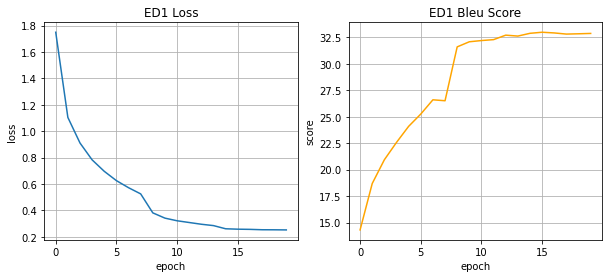

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('ED1 Loss')
plt.grid(True)

ax2 = fig.add_subplot(122)
plt.plot(score_1,'orange')
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('ED1 Bleu Score')
plt.grid(True)

fig.savefig('ED1.jpg')

In [ ]:
#if False:
#  path_ed1 =  '/content/drive/My Drive/HW2/model/ED1.pt'

 # torch.save({
 #     'loss_cache': loss_ed1,
 #     'bleu_cache': score_ed1,
 #     'model_dict': ED1.state_dict()
 # }, path_ed1)

  # loss_1 = torch.load('/content/drive/My Drive/HW2/model/ED1.pt')['loss_cache']

  #ED1.load_state_dict(torch.load('/content/drive/My Drive/HW2/model/ED1.pt')['model_dict'])
  # ED1.to(device)

In [ ]:
loss_ed2, score_ed2 = train_model(dataloader_dict, ED2, num_epochs = num_epochs, saved_model_path = saved_models_dir, enc_type = 'decoder_rnn')

Epoch: [1/20]


epoch 0 loss = 2.2658440652646514, time = 406.2739326953888
validation bleu:  8.313330038830264
Epoch: [2/20]


epoch 1 loss = 1.4365901269410786, time = 405.14541387557983
validation bleu:  13.662324088726583
Epoch: [3/20]


epoch 2 loss = 1.218615063802027, time = 405.5273973941803
validation bleu:  15.97558266853208
Epoch: [4/20]


epoch 3 loss = 1.1139900477308975, time = 407.860960483551
validation bleu:  17.135984030589068
Epoch: [5/20]


epoch 4 loss = 1.0317283092113083, time = 406.57360553741455
validation bleu:  18.303612590275808
Epoch: [6/20]


epoch 5 loss = 0.9726420902479388, time = 405.63511991500854
validation bleu:  18.87211599923324
Epoch: [7/20]


epoch 6 loss = 0.9302324780136595, time = 404.06235456466675
validation bleu:  20.287722954569364
Epoch: [8/20]


epoch 7 loss = 0.8959685144331977, time = 404.22323536872864
validation bleu:  19.789825754390556
Epoch     7: reducing learning rate of group 0 to 2.5000e-03.
Epoch: [9/20]


epoch 8 loss = 0.7848035015557941, time = 404.0092701911926
validation bleu:  25.346364085668206
Epoch: [10/20]


epoch 9 loss = 0.7357260711470469, time = 405.56809997558594
validation bleu:  25.960553263659104
Epoch: [11/20]


epoch 10 loss = 0.7093630738535747, time = 405.0353660583496
validation bleu:  26.66858968901857
Epoch: [12/20]


epoch 11 loss = 0.6915957222850039, time = 407.74608540534973
validation bleu:  26.995120335003985
Epoch: [13/20]


epoch 12 loss = 0.6752249863999702, time = 404.6484773159027
validation bleu:  27.578294729738232
Epoch: [14/20]


epoch 13 loss = 0.6605709833616695, time = 400.95221424102783
validation bleu:  27.983798769623245
Epoch: [15/20]


epoch 14 loss = 0.6460336047031212, time = 406.22712206840515
validation bleu:  28.530878027639858
Epoch: [16/20]


epoch 15 loss = 0.6324405216939561, time = 401.38288927078247
validation bleu:  28.202411655032265
Epoch    15: reducing learning rate of group 0 to 2.5000e-04.
Epoch: [17/20]


epoch 16 loss = 0.6129984417285285, time = 399.39747405052185
validation bleu:  28.775064647524307
Epoch: [18/20]


epoch 17 loss = 0.6112653794050877, time = 402.8596122264862
validation bleu:  28.78334307917276
Epoch: [19/20]


epoch 18 loss = 0.6055758088579468, time = 401.0893044471741
validation bleu:  28.840438450258695
Epoch: [20/20]


epoch 19 loss = 0.6054838253025203, time = 400.0085680484772
validation bleu:  28.879453695723818


In [ ]:

path_ed2 =  '/content/drive/My Drive/HW2/model/ED2.pt'

torch.save({
    'loss_cache': loss_ed2,
    'bleu_cache': score_ed2,
    'model': ED2
}, path_ed2)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderTransformer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
ED2 = torch.load('/content/drive/My Drive/HW2/model/ED2.pt')['model']
ED2.to(device)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512)
    (

In [ ]:
loss_2 = torch.load('/content/drive/My Drive/HW2/model/ED2.pt')['loss_cache']
score_2 = torch.load('/content/drive/My Drive/HW2/model/ED2.pt')['bleu_cache']

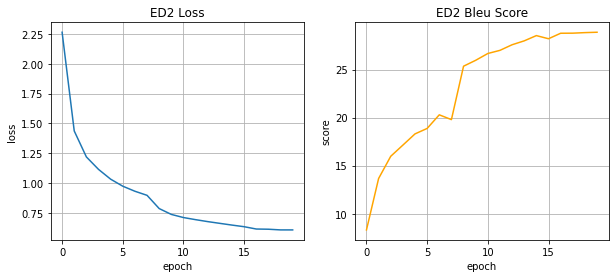

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('ED2 Loss')
plt.grid(True)

ax2 = fig.add_subplot(122)
plt.plot(score_2,'orange')
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('ED2 Bleu Score')
plt.grid(True)

fig.savefig('ED2.jpg')

In [ ]:
loss_ed3, score_ed3 = train_model(dataloader_dict, ED3, num_epochs = num_epochs, saved_model_path = saved_models_dir, enc_type = 'decoder_rnn')

Epoch: [1/20]


epoch 0 loss = 2.3371414355624087, time = 447.119366645813
validation bleu:  7.334891976231707
Epoch: [2/20]


epoch 1 loss = 1.4209533547760707, time = 445.56304907798767
validation bleu:  13.31134370515123
Epoch: [3/20]


epoch 2 loss = 1.1482551166225339, time = 441.96139645576477
validation bleu:  16.887857229283792
Epoch: [4/20]


epoch 3 loss = 1.0153549697260447, time = 441.2395730018616
validation bleu:  18.64575810317692
Epoch: [5/20]


epoch 4 loss = 0.9311252616779295, time = 441.7263686656952
validation bleu:  19.57909003224914
Epoch: [6/20]


epoch 5 loss = 0.8771759038321529, time = 441.48950695991516
validation bleu:  20.05496921252745
Epoch: [7/20]


epoch 6 loss = 0.8373392744903089, time = 443.71416544914246
validation bleu:  21.19631118071006
Epoch: [8/20]


epoch 7 loss = 0.796038991113779, time = 442.657781124115
validation bleu:  21.960147025740273
Epoch: [9/20]


epoch 8 loss = 0.7652986836565498, time = 440.1208348274231
validation bleu:  22.519841108860657
Epoch: [10/20]


epoch 9 loss = 0.7397611493384079, time = 441.226758480072
validation bleu:  22.61350418654686
Epoch: [11/20]


epoch 10 loss = 0.7149512603342368, time = 440.2691888809204
validation bleu:  22.958166783826528
Epoch: [12/20]


epoch 11 loss = 0.690218723645831, time = 440.08635354042053
validation bleu:  23.258056208990567
Epoch: [13/20]


epoch 12 loss = 0.6727923645702425, time = 442.4799427986145
validation bleu:  24.21556739139068
Epoch: [14/20]


epoch 13 loss = 0.6577016612664485, time = 443.8106324672699
validation bleu:  23.330987195302
Epoch    13: reducing learning rate of group 0 to 2.5000e-03.
Epoch: [15/20]


epoch 14 loss = 0.5623422794229767, time = 443.96692633628845
validation bleu:  27.71083773603481
Epoch: [16/20]


epoch 15 loss = 0.5223313950930936, time = 443.38410353660583
validation bleu:  28.39289246516149
Epoch: [17/20]


epoch 16 loss = 0.49851218884671494, time = 440.5261380672455
validation bleu:  28.730875050180085
Epoch: [18/20]


epoch 17 loss = 0.48108011494052705, time = 440.3348014354706
validation bleu:  29.41842320574593
Epoch: [19/20]


epoch 18 loss = 0.46656205101026393, time = 442.9153347015381
validation bleu:  29.277450663044245
Epoch    18: reducing learning rate of group 0 to 2.5000e-04.
Epoch: [20/20]


epoch 19 loss = 0.4474037732609091, time = 441.9919810295105
validation bleu:  29.769775415231152
Training completed. Best BLEU is 29.769775415231152


In [ ]:

path_ed3 =  '/content/drive/My Drive/HW2/model/ED3.pt'

torch.save({
    'loss_cache': loss_ed3,
    'bleu_cache': score_ed3,
    'model': ED3
}, path_ed3)



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderTransformer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
loss_3 = torch.load('/content/drive/My Drive/HW2/model/ED3.pt')['loss_cache']
score_3 = torch.load('/content/drive/My Drive/HW2/model/ED3.pt')['bleu_cache']

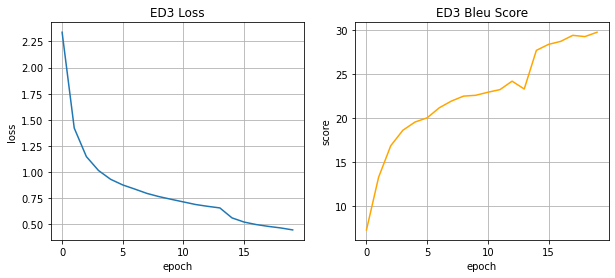

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('ED3 Loss')
plt.grid(True)

ax2 = fig.add_subplot(122)
plt.plot(score_3,'orange')
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('ED3 Bleu Score')
plt.grid(True)

#fig.savefig('ED3.jpg')

In [ ]:
# Load model

In [33]:
loss_1 = torch.load('/content/drive/My Drive/HW2/model/ED1.pt')['loss_cache']
score_1 = torch.load('/content/drive/My Drive/HW2/model/ED1.pt')['bleu_cache']
ED1 =  torch.load('/content/drive/My Drive/HW2/model/ED1.pt')['model']
ED1.to(device)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(20111, 512)
    (gru): GRU(512, 512, batch_first=True)
    (

In [46]:
loss_2 = torch.load('/content/drive/My Drive/HW2/model/ED2.pt')['loss_cache']
score_2 = torch.load('/content/drive/My Drive/HW2/model/ED2.pt')['bleu_cache']
ED2 =  torch.load('/content/drive/My Drive/HW2/model/ED2.pt')['model']
ED2.to(device)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512)
    (

In [49]:
loss_3 = torch.load('/content/drive/My Drive/HW2/model/ED3.pt')['loss_cache']
score_3 = torch.load('/content/drive/My Drive/HW2/model/ED3.pt')['bleu_cache']
ED3 =  torch.load('/content/drive/My Drive/HW2/model/ED3.pt')['model']
ED3.to(device)

seq2seq(
  (encoder): EncoderTransformer(
    (token_embed): Embedding(12392, 512)
    (position_embed): PositionalEncoding(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.0, inplace=False)
          (dropout2): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (decoder): Decoder_SelfAttn(
    (embedding): Embedding(20111, 512)
    (memory_rnn): GRUCell(1024, 512)
    (

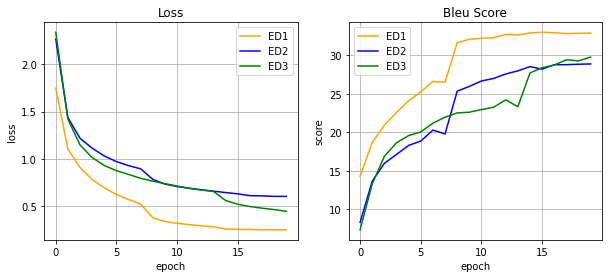

In [58]:
# Plot
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
plt.plot(loss_1, 'orange',label='ED1')
plt.plot(loss_2,'blue',label='ED2')
plt.plot(loss_3,'green',label='ED3')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')
plt.grid(True)
plt.legend()


ax2 = fig.add_subplot(122)
plt.plot(score_1,'orange',label='ED1')
plt.plot(score_2,'blue',label='ED2')
plt.plot(score_3,'green',label='ED3')
plt.xlabel('epoch')
plt.ylabel('score')
plt.title('Bleu Score')
plt.grid(True)
plt.legend()
fig.savefig('Summary.jpg')

---
### 2 Attention visualization (12 pts)

In [34]:
import copy
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def get_binned_bl_score(nmt_model, val_dataset):
    
#     source_len = np.sort(np.array(val_dataset.main_df['source_len']))
#     len_threshold = [0]+[source_len[x*1000+376] for x in range(1, 21)];
#     len_threshold = np.unique(len_threshold)
    len_threshold = np.arange(0, 31, 5)
    bin_bl_score = np.zeros(len(len_threshold));
    
    for i in notebook.tqdm(range(1, len(len_threshold)), total = len(len_threshold)-1):
        min_len = len_threshold[i-1]
#         min_len = 0
        max_len = len_threshold[i]
        
        temp_dataset = copy.deepcopy(val_dataset);
        temp_dataset.main_df = temp_dataset.main_df[(temp_dataset.main_df['source_len'] > min_len) & (temp_dataset.main_df['source_len'] <= max_len)];
        temp_loader = DataLoader(temp_dataset, batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=100),
                            shuffle = True, num_workers=0)
        
        bin_bl_score[i] = nmt_model.get_bleu_score(temp_loader);
        
    
    len_threshold = len_threshold[1:]
    bin_bl_score = bin_bl_score[1:]
    
    plt.plot(len_threshold, bin_bl_score, 'x-')
    plt.ylim(0, np.max(bin_bl_score)+1)
    plt.xlabel('len')
    plt.ylabel('bl score')
    
    return len_threshold, bin_bl_score
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('souce: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
    print('GT on sentence (src->tgt): ', translator.translate(sentence, 
                                                     src = source_name,
                                                     dest = target_name).text)
    print('GT on prediction (tgt->src): ', translator.translate(prediction, 
                                                     src = target_name,
                                                     dest = source_name).text)

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [35]:
!pip install googletrans
from googletrans import Translator
translator = Translator()

In [42]:
! head -10 'data/valid.en'

you seem happy .
what right do you have to order us around ?
business expenses are tax deductible .
i can t do two things at once .
unfortunately i have to disappoint you .
is this correct ?
i don t blame them for this .
do you have a cellphone ?
promise me you ll be careful .
she knows better than to argue with him .


### Basic RNN decoder (no attention)


In [55]:
get_translation(ED1, 'you seem happy .', source_lang_obj, use_cuda)

souce:  you seem happy .
prediction:  tu sembles heureux .
GT on sentence (src->tgt):  tu as l'air heureux .
GT on prediction (tgt->src):  you seem happy.


In [44]:
get_translation(ED1, 'promise me you ll be careful .', source_lang_obj, use_cuda)

souce:  promise me you ll be careful .
prediction:  promets moi que tu seras prudent !
GT on sentence (src->tgt):  promettez-moi que vous serez prudent.
GT on prediction (tgt->src):  promise me you'll be careful!


In [52]:
get_translation(ED1, 'do you have a cellphone ?', source_lang_obj, use_cuda)

souce:  do you have a cellphone ?
prediction:  as tu un petit mobile ?
GT on sentence (src->tgt):  est-ce que vous avez un téléphone portable ?
GT on prediction (tgt->src):  do you have a small mobile?


### RNN Decoder with Encoder attention

souce:  you seem happy .
prediction:  vous semblez heureuses .
GT on sentence (src->tgt):  tu as l'air heureux .
GT on prediction (tgt->src):  you seem happy.


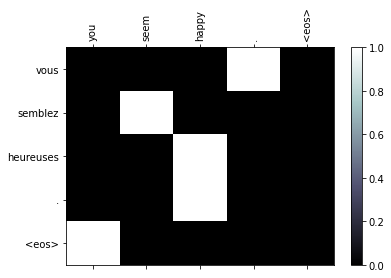

In [56]:
get_translation(ED2, 'you seem happy .', source_lang_obj, use_cuda)

souce:  promise me you ll be careful .
prediction:  d etre que tu seras prudent !
GT on sentence (src->tgt):  promettez-moi que vous serez prudent.
GT on prediction (tgt->src):  to be that you will be careful!


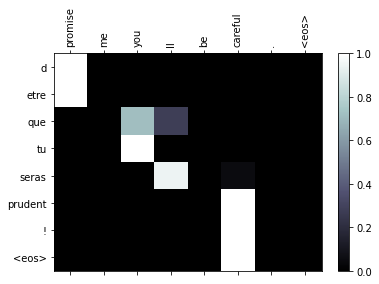

In [48]:
get_translation(ED2, 'promise me you ll be careful .', source_lang_obj, use_cuda)

souce:  do you have a cellphone ?
prediction:  avez vous un coup de soleil ?
GT on sentence (src->tgt):  est-ce que vous avez un téléphone portable ?
GT on prediction (tgt->src):  are you sunburned?


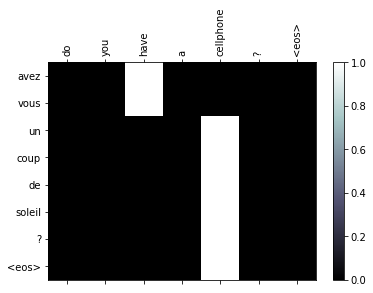

In [53]:
get_translation(ED2, 'do you have a cellphone ?', source_lang_obj, use_cuda)

### RNN Decoder with Encoder & Self attention

souce:  you seem happy .
prediction:  vous semblez heureux .
GT on sentence (src->tgt):  tu as l'air heureux .
GT on prediction (tgt->src):  you seem happy.


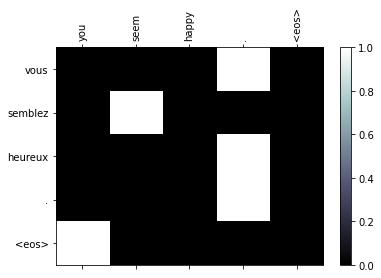

In [57]:
get_translation(ED3, 'you seem happy .', source_lang_obj, use_cuda)

souce:  promise me you ll be careful .
prediction:  promettez moi que vous serez prudente .
GT on sentence (src->tgt):  promettez-moi que vous serez prudent.
GT on prediction (tgt->src):  promise me you'll be careful.


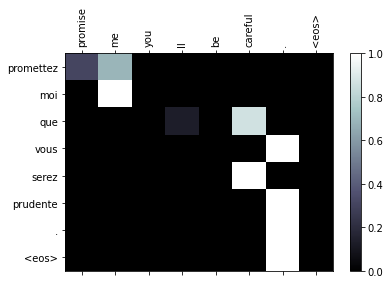

In [51]:
get_translation(ED3, 'promise me you ll be careful .', source_lang_obj, use_cuda)

souce:  do you have a cellphone ?
prediction:  avez vous un appareil photo ?
GT on sentence (src->tgt):  est-ce que vous avez un téléphone portable ?
GT on prediction (tgt->src):  do you have a camera ?


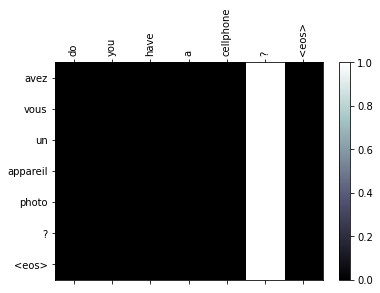

In [54]:
get_translation(ED3, 'do you have a cellphone ?', source_lang_obj, use_cuda)

In [ ]:
# Model was trained in ~2 hours, i.e. you can expect attention maps
# to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input
# Code Cited https://nlp.seas.harvard.edu/2018/04/03/attention.html